In [70]:
import statsmodels.api as sm
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Loading/Cleaning Data

In [5]:
data = pd.read_csv(r'drugs.csv')
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,Amphet
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,CL2
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,CL2
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,CL1


In [6]:
cols = []
featured = data.iloc[:, data.columns != 'Amphet']
for column in featured:
    cols.append(column)
label = 'Amphet'

data['Amphet'] = data['Amphet'].map({'CL0': 0, 
                                     'CL1': 0, 
                                     'CL2': 1, 
                                     'CL3': 1, 
                                     'CL4': 1, 
                                     'CL5': 1,
                                     'CL6': 1})
X = data[cols]
y = data[label]

### Filtering out input variables with the least significant impact on meth use

In [7]:
logit_model=sm.Logit(y,X)               # runs the model
result=logit_model.fit()
results_summary = result.summary2()

Optimization terminated successfully.
         Current function value: 0.534957
         Iterations 6


In [8]:
p_values_tables = results_summary.tables[1]['P>|z|'].tolist()

p_values = {}                   # dictionary of the p_values
for i in range(0, len(p_values_tables)):
    p_values[results_summary.tables[1]['P>|z|'].index[i]] = p_values_tables[i]
    #p_values[i]# p_values_tables[i]

p_values_tailored = {}          # dictionary of all p_values under 0.05, ie the ones that are statistically significant
for i in range(0, len(p_values_tables)):
    if(list(p_values.values())[i] < 0.05):
        p_values_tailored[results_summary.tables[1]['P>|z|'].index[i]] = list(p_values.values())[i]
print(p_values_tailored)

{'Age': 7.266884157938046e-11, 'Gender': 6.687757332475755e-08, 'Education': 0.04432779272147318, 'Country': 1.2928650250907023e-14, 'Ethnicity': 4.1609051405562617e-13, 'Oscore': 0.006157688036376886, 'Cscore': 0.01445978954950491, 'Impulsive': 1.2177204749193962e-05}


In [9]:
def pruneDataset(dataset, selectedFeatures):
    features = dataset.filter(regex='|'.join(selectedFeatures))
    
    return features

newX = pruneDataset(featured, p_values_tailored.keys())

# SVM Model

In [11]:
def classification_accuracy(model, x_train, y_train, x_test, y_test):
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    train_error = np.sum(y_pred_train != y_train) / (1.0 * x_train.shape[0])
    test_error = np.sum(y_pred_test != y_test) / (1.0 * x_test.shape[0])
    return 1-train_error, 1-test_error, y_pred_train, y_pred_test

In [12]:
def run_SVM(X_train, y_train, X_test, y_test, kernel='linear', penalty=0):
    svm = SVC(kernel=kernel, C=penalty).fit(X_train, y_train)

    train_acc, test_acc, _, y_pred_test \
    = classification_accuracy(svm, X_train, y_train, X_test, y_test)

    return svm, train_acc, test_acc, y_pred_test

### Tuning Margin-Softness Hyperparam

In [62]:
TRIALS = 30
accs_end=[0 for i in range(int(((60-5)/3)+1))]

for trial in range(TRIALS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rbf_accs = []
    penalties = []
    
    for penalty in range(5,60,3):

        penalties.append((penalty/10))

        svm, train_acc, test_acc, y_pred_test \
            = run_SVM(X_train, y_train, X_test, y_test, kernel='rbf', penalty=(penalty/10))

        rbf_accs.append(test_acc)

    accs_end=[(accs_end[i] + rbf_accs[i]) for i in range(len(rbf_accs))]

accs_end=[(accs_end[i]/TRIALS) for i in range(len(accs_end))] 

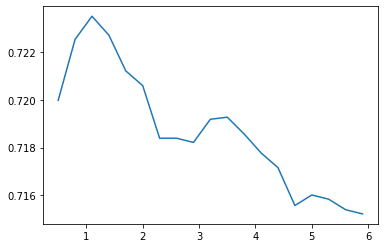

In [73]:
max_find = list(zip(penalties,accs_end))

tuned_C = 0

for i in max_find:
    if i[1] == max(accs_end):
        tuned_C = i[0]

plt.plot(penalties,accs_end)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm, train_acc, test_acc, y_pred_test \
            = run_SVM(X_train, y_train, X_test, y_test, kernel='rbf', penalty=tuned_C)

y_true = np.array(y_test)
print(classification_report(y_true, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       257
           1       0.59      0.63      0.61       120

    accuracy                           0.74       377
   macro avg       0.71      0.71      0.71       377
weighted avg       0.75      0.74      0.75       377

